In [ ]:
#svm model

In [ ]:
#lag 1

In [ ]:
#svm+fin, text, vader

Merged Data Date Range:
2021-12-17 00:00:00 2022-12-30 00:00:00
Validation Mean Squared Error: 0.15411287598973503
Validation R^2 Score: 0.9880711770885275
Test Mean Squared Error: 0.22693272034511258
Test Root Mean Squared Error: 0.4763745588768491
Test Mean Absolute Error: 0.3355763809433927
Test R^2 Score: 0.9819400231100581


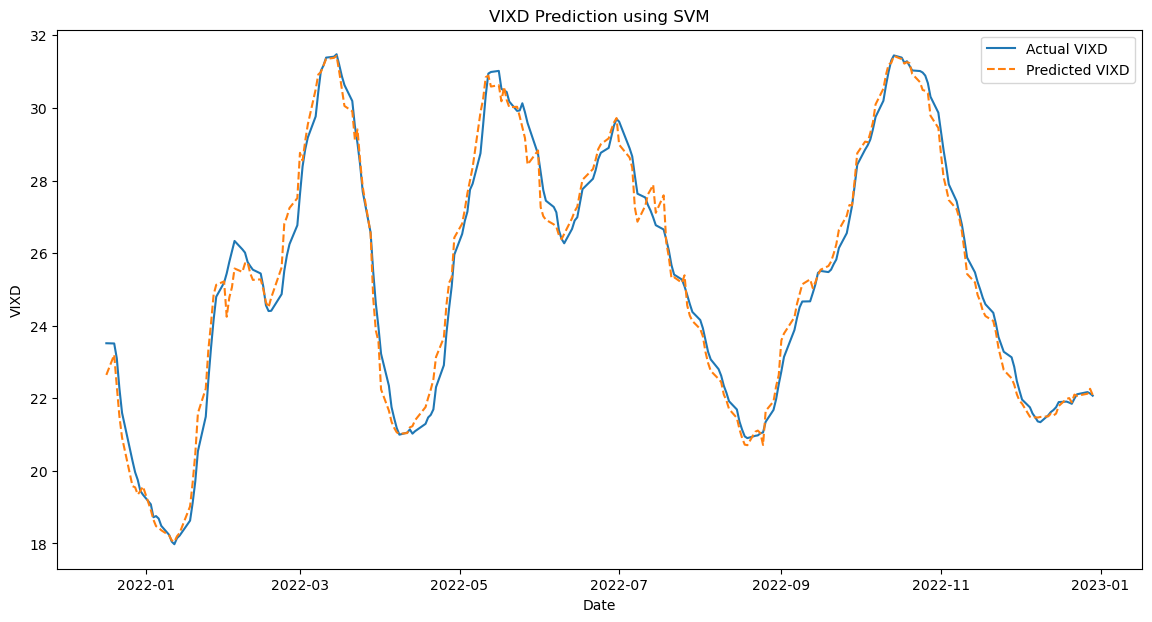

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

# Load sentiment and market index data
finbert_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_finbert.xlsx')
textblob_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_textblob.xlsx')
vader_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_vader.xlsx')
spxd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/_SPXD.xlsx', sheet_name='Price Data')
spxtrd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/_SPXTRD.xlsx', sheet_name='Price Data')
vixd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/VIXD.xlsx', sheet_name='Price Data')

# Ensure date columns are datetime type
for df in [finbert_data, textblob_data, vader_data, spxd_data, spxtrd_data, vixd_data]:
    df['Date'] = pd.to_datetime(df['Date'])

# Function to expand sentiment scores to daily
def expand_to_daily(data):
    return data.set_index('Date').resample('D').ffill().reset_index()

finbert_data_daily = expand_to_daily(finbert_data)
textblob_data_daily = expand_to_daily(textblob_data)
vader_data_daily = expand_to_daily(vader_data)

# Merge sentiment score data
sentiment_data = pd.merge(finbert_data_daily, textblob_data_daily, on='Date', how='outer', suffixes=('_finbert', '_textblob'))
sentiment_data = pd.merge(sentiment_data, vader_data_daily, on='Date', how='outer')

# Merge market index data
market_data = pd.merge(spxd_data, spxtrd_data, on='Date', how='outer', suffixes=('_spxd', '_spxtrd'))
market_data = pd.merge(market_data, vixd_data, on='Date', how='outer')

# Merge all data
data = pd.merge(sentiment_data, market_data, on='Date', how='outer')
data.set_index('Date', inplace=True)

# Drop rows with NaN values
data.dropna(inplace=True)

# Check merged data date range
print("Merged Data Date Range:")
print(data.index.min(), data.index.max())

# Select features and target
X = data[['Overall Positive Sentiment', 'Overall Neutral Sentiment', 'Overall Negative Sentiment', 
          'Polarity', 'Subjectivity', 
          'Positive', 'Neutral', 'Negative', 
          'Average_SPXD', 'Close_SPXD', 'Close_SPXTRD', 'Average_SPXTRD']]
y = data['Average_VIXD'].shift(-1)

# Drop NaN values from the target variable and align features
y = y.dropna()
X = X.loc[y.index]

# Apply weights to features
weights = {
    'Overall Positive Sentiment': 0.1,
    'Overall Neutral Sentiment': 0.7,
    'Overall Negative Sentiment': 0.1,
    'Polarity': 0.5,
    'Subjectivity': 0.5,
    'Positive': 0.5,
    'Neutral': 0.5,
    'Negative': 0.7,
    'Average_SPXD': 0.7,
    'Close_SPXD': 0.7,
    'Close_SPXTRD': 0.7,
    'Average_SPXTRD': 0.7
}
for col, weight in weights.items():
    X[col] = X[col] * weight

# Ensure features and target are aligned
X = X.loc[y.index]
data = data.loc[y.index]  # Synchronize deletion in data

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build SVM model
svm_model = SVR(kernel='rbf', C=1500, gamma=0.1)
svm_model.fit(X_train, y_train)

# Evaluate model on validation set
y_val_pred = svm_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation Mean Squared Error: {val_mse}')
print(f'Validation R^2 Score: {val_r2}')

y_test_pred = svm_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test Mean Squared Error: {test_mse}')
print(f'Test Root Mean Squared Error: {test_rmse}')
print(f'Test Mean Absolute Error: {test_mae}')
print(f'Test R^2 Score: {test_r2}')

# Visualize prediction results
predicted_vixd = svm_model.predict(X_scaled)
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Average_VIXD'], label='Actual VIXD')
plt.plot(data.index, predicted_vixd, label='Predicted VIXD', linestyle='--')
plt.xlabel('Date')
plt.ylabel('VIXD')
plt.title('VIXD Prediction using SVM')
plt.legend()
plt.show()


In [3]:
import scipy.stats as stats

# 计算F统计量和P值
def calculate_f_p_values(y_true, y_pred, model, X):
    n = len(y_true)  # 样本数
    k = X.shape[1]  # 特征数
    ssr = np.sum((y_pred - y_true.mean()) ** 2)  # 回归平方和
    sse = np.sum((y_true - y_pred) ** 2)  # 残差平方和
    msr = ssr / k  # 回归均方
    mse = sse / (n - k - 1)  # 残差均方
    f_stat = msr / mse  # F统计量
    p_value = stats.f.sf(f_stat, k, n - k - 1)  # P值
    return f_stat, p_value

# 对验证集进行计算
f_stat_val, p_value_val = calculate_f_p_values(y_val, y_val_pred, svm_model, X_val)
print(f'Validation F-statistic: {f_stat_val}')
print(f'Validation P-value: {p_value_val}')

# 对测试集进行计算
f_stat_test, p_value_test = calculate_f_p_values(y_test, y_test_pred, svm_model, X_test)
print(f'Test F-statistic: {f_stat_test}')
print(f'Test P-value: {p_value_test}')


Validation F-statistic: 274.17850629054755
Validation P-value: 9.848613912882068e-34
Test F-statistic: 182.1354721861089
Test P-value: 2.4840678367313592e-30


In [ ]:
# lag 2

Merged Data Date Range:
2021-12-17 00:00:00 2022-12-30 00:00:00
Validation Mean Squared Error: 0.3598589626731492
Validation R^2 Score: 0.9667799482386981
Test Mean Squared Error: 0.1379027607838869
Test Root Mean Squared Error: 0.37135260977120776
Test Mean Absolute Error: 0.2789651218066276
Test R^2 Score: 0.9898598050906456


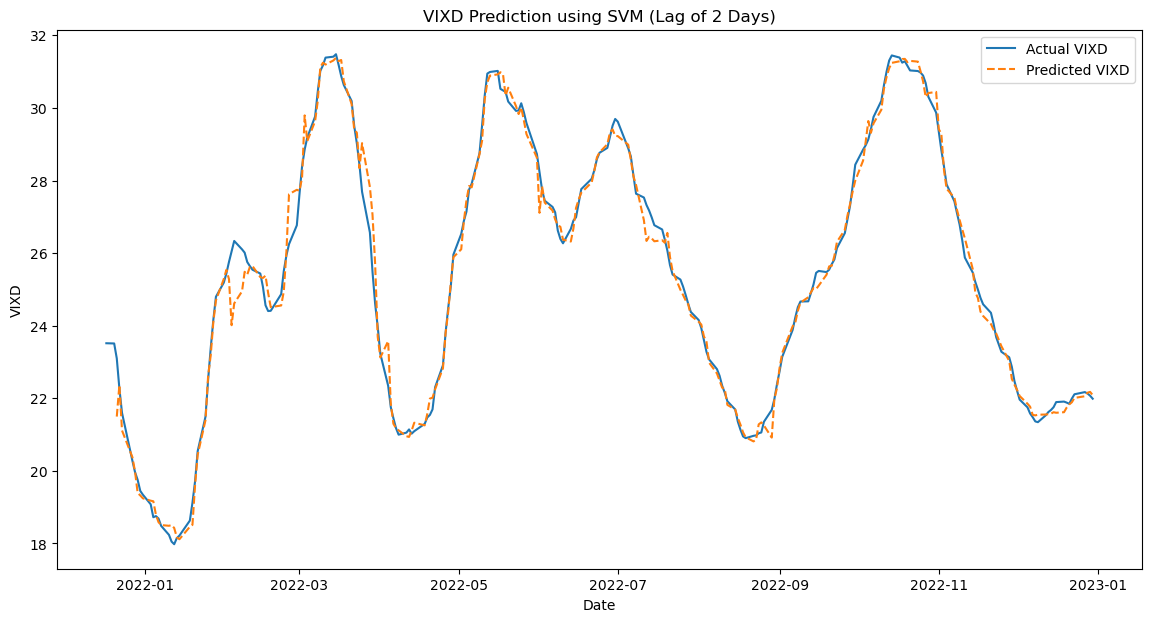

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

# Load sentiment and market index data
finbert_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_finbert.xlsx')
textblob_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_textblob.xlsx')
vader_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_vader.xlsx')
spxd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/_SPXD.xlsx', sheet_name='Price Data')
spxtrd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/_SPXTRD.xlsx', sheet_name='Price Data')
vixd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/VIXD.xlsx', sheet_name='Price Data')

# Ensure date columns are datetime type
for df in [finbert_data, textblob_data, vader_data, spxd_data, spxtrd_data, vixd_data]:
    df['Date'] = pd.to_datetime(df['Date'])

# Function to expand sentiment scores to daily
def expand_to_daily(data):
    return data.set_index('Date').resample('D').ffill().reset_index()

finbert_data_daily = expand_to_daily(finbert_data)
textblob_data_daily = expand_to_daily(textblob_data)
vader_data_daily = expand_to_daily(vader_data)

# Merge sentiment score data
sentiment_data = pd.merge(finbert_data_daily, textblob_data_daily, on='Date', how='outer', suffixes=('_finbert', '_textblob'))
sentiment_data = pd.merge(sentiment_data, vader_data_daily, on='Date', how='outer')

# Merge market index data
market_data = pd.merge(spxd_data, spxtrd_data, on='Date', how='outer', suffixes=('_spxd', '_spxtrd'))
market_data = pd.merge(market_data, vixd_data, on='Date', how='outer')

# Merge all data
data = pd.merge(sentiment_data, market_data, on='Date', how='outer')
data.set_index('Date', inplace=True)

# Drop rows with NaN values
data.dropna(inplace=True)

# Check merged data date range
print("Merged Data Date Range:")
print(data.index.min(), data.index.max())

# Select features and target with a lag of 2 days
lag = 2
X = data[['Overall Positive Sentiment', 'Overall Neutral Sentiment', 'Overall Negative Sentiment', 
          'Polarity', 'Subjectivity', 
          'Positive', 'Neutral', 'Negative', 
          'Average_SPXD', 'Close_SPXD', 'Close_SPXTRD', 'Average_SPXTRD']]

# Apply lag to the features
X_lagged = X.shift(lag)
y = data['Average_VIXD']

# Drop NaN values from the features and target variable
X_lagged = X_lagged.dropna()
y = y.loc[X_lagged.index]

# Apply weights to features
weights = {
    'Overall Positive Sentiment': 0.1,
    'Overall Neutral Sentiment': 0.7,
    'Overall Negative Sentiment': 0.1,
    'Polarity': 0.8,
    'Subjectivity': 0.5,
    'Positive': 0.1,
    'Neutral': 0.1,
    'Negative': 0.5,
    'Average_SPXD': 0.9,
    'Close_SPXD': 0.9,
    'Close_SPXTRD': 0.9,
    'Average_SPXTRD': 0.9
}
for col, weight in weights.items():
    X_lagged[col] = X_lagged[col] * weight

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_lagged)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build SVM model
svm_model = SVR(kernel='rbf', C=1500, gamma=0.1)
svm_model.fit(X_train, y_train)

# Evaluate model on validation set
y_val_pred = svm_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation Mean Squared Error: {val_mse}')
print(f'Validation R^2 Score: {val_r2}')

y_test_pred = svm_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test Mean Squared Error: {test_mse}')
print(f'Test Root Mean Squared Error: {test_rmse}')
print(f'Test Mean Absolute Error: {test_mae}')
print(f'Test R^2 Score: {test_r2}')

# Visualize prediction results
predicted_vixd = svm_model.predict(X_scaled)
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Average_VIXD'], label='Actual VIXD')
plt.plot(data.index[lag:], predicted_vixd, label='Predicted VIXD', linestyle='--')
plt.xlabel('Date')
plt.ylabel('VIXD')
plt.title('VIXD Prediction using SVM (Lag of 2 Days)')
plt.legend()
plt.show()



In [7]:
import scipy.stats as stats

# 计算F统计量和P值
def calculate_f_p_values(y_true, y_pred, model, X):
    n = len(y_true)  # 样本数
    k = X.shape[1]  # 特征数
    ssr = np.sum((y_pred - y_true.mean()) ** 2)  # 回归平方和
    sse = np.sum((y_true - y_pred) ** 2)  # 残差平方和
    msr = ssr / k  # 回归均方
    mse = sse / (n - k - 1)  # 残差均方
    f_stat = msr / mse  # F统计量
    p_value = stats.f.sf(f_stat, k, n - k - 1)  # P值
    return f_stat, p_value

# 对验证集进行计算
f_stat_val, p_value_val = calculate_f_p_values(y_val, y_val_pred, svm_model, X_val)
print(f'Validation F-statistic: {f_stat_val}')
print(f'Validation P-value: {p_value_val}')

# 对测试集进行计算
f_stat_test, p_value_test = calculate_f_p_values(y_test, y_test_pred, svm_model, X_test)
print(f'Test F-statistic: {f_stat_test}')
print(f'Test P-value: {p_value_test}')


Validation F-statistic: 101.30071387987117
Validation P-value: 1.6485776442799503e-25
Test F-statistic: 316.74501454404765
Test P-value: 6.134524376683841e-35


In [ ]:
#lstm

C:\Users\22749\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\22749\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\22749\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\22749\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\f

Merged Data Date Range:
2021-12-17 00:00:00 2022-12-30 00:00:00
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 155 samples, validate on 52 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/1000
155/155 - 5s - loss: 674.4041 - val_loss: 620.0755
Epoch 2/1000
155/155 - 0s - loss: 672.6774 - val_loss: 618.3267
Epoch 3/1000
155/155 - 0s - loss: 670.3162 - val_loss: 616.1875
Epoch 4/1000
155/155 - 0s - loss: 667.7648 - val_loss: 613.4455
Epoch 5/1000
155/155 - 0s - loss: 664.1485 - val_loss: 609.7524
Epoch 6/1000
155/155 - 0s - loss: 659.0145 - val_loss: 604.5907
Epoch 7/1000
155/155 - 0s - loss: 652.7432 - val_loss: 597.2727
Epoch 8/1000
155/155 - 0s - loss: 641.0244 - val_loss: 586.9476
Epoch 9/1000
155/155 - 0s - loss: 629.3381 - val_loss: 573.0088
Epoch 10/1000
155/155 - 0s - loss: 610.9991 - val_loss: 555.1210
Epoch 11/1000
155/155 - 0s - loss: 588

Epoch 117/1000
155/155 - 0s - loss: 23.8114 - val_loss: 14.2761
Epoch 118/1000
155/155 - 0s - loss: 26.7385 - val_loss: 14.2603
Epoch 119/1000
155/155 - 0s - loss: 24.4268 - val_loss: 14.2482
Epoch 120/1000
155/155 - 0s - loss: 24.7389 - val_loss: 14.2428
Epoch 121/1000
155/155 - 0s - loss: 26.3379 - val_loss: 14.2454
Epoch 122/1000
155/155 - 0s - loss: 21.0628 - val_loss: 14.2477
Epoch 123/1000
155/155 - 0s - loss: 23.8403 - val_loss: 14.2447
Epoch 124/1000
155/155 - 0s - loss: 27.6121 - val_loss: 14.2302
Epoch 125/1000
155/155 - 0s - loss: 21.2726 - val_loss: 14.2171
Epoch 126/1000
155/155 - 0s - loss: 25.9324 - val_loss: 14.2199
Epoch 127/1000
155/155 - 0s - loss: 24.6192 - val_loss: 14.2052
Epoch 128/1000
155/155 - 0s - loss: 27.0257 - val_loss: 14.2101
Epoch 129/1000
155/155 - 0s - loss: 28.3048 - val_loss: 14.2122
Epoch 130/1000
155/155 - 0s - loss: 22.9775 - val_loss: 14.2196
Epoch 131/1000
155/155 - 0s - loss: 22.3923 - val_loss: 14.2012
Epoch 132/1000
155/155 - 0s - loss: 26.8

155/155 - 0s - loss: 20.1002 - val_loss: 8.6572
Epoch 247/1000
155/155 - 0s - loss: 18.8571 - val_loss: 8.5987
Epoch 248/1000
155/155 - 0s - loss: 21.4183 - val_loss: 8.5777
Epoch 249/1000
155/155 - 0s - loss: 18.8308 - val_loss: 8.5597
Epoch 250/1000
155/155 - 0s - loss: 18.2886 - val_loss: 8.5370
Epoch 251/1000
155/155 - 0s - loss: 18.6836 - val_loss: 8.5603
Epoch 252/1000
155/155 - 0s - loss: 16.3039 - val_loss: 8.5413
Epoch 253/1000
155/155 - 0s - loss: 17.7539 - val_loss: 8.5543
Epoch 254/1000
155/155 - 0s - loss: 19.0741 - val_loss: 8.5977
Epoch 255/1000
155/155 - 0s - loss: 19.0332 - val_loss: 8.6468
Epoch 256/1000
155/155 - 0s - loss: 18.8051 - val_loss: 8.6323
Epoch 257/1000
155/155 - 0s - loss: 17.7987 - val_loss: 8.5783
Epoch 258/1000
155/155 - 0s - loss: 16.2446 - val_loss: 8.5988
Epoch 259/1000
155/155 - 0s - loss: 17.0201 - val_loss: 8.5739
Epoch 260/1000
155/155 - 0s - loss: 17.2417 - val_loss: 8.4633
Epoch 261/1000
155/155 - 0s - loss: 17.6895 - val_loss: 8.3768
Epoch 2

Epoch 377/1000
155/155 - 0s - loss: 14.7752 - val_loss: 4.0010
Epoch 378/1000
155/155 - 0s - loss: 11.1824 - val_loss: 3.9706
Epoch 379/1000
155/155 - 0s - loss: 13.6150 - val_loss: 4.0451
Epoch 380/1000
155/155 - 0s - loss: 15.3151 - val_loss: 4.0366
Epoch 381/1000
155/155 - 0s - loss: 12.4084 - val_loss: 4.0014
Epoch 382/1000
155/155 - 0s - loss: 13.0754 - val_loss: 3.9888
Epoch 383/1000
155/155 - 0s - loss: 14.7326 - val_loss: 3.9932
Epoch 384/1000
155/155 - 0s - loss: 12.7630 - val_loss: 4.0835
Epoch 385/1000
155/155 - 0s - loss: 14.8211 - val_loss: 4.0872
Epoch 386/1000
155/155 - 0s - loss: 15.0634 - val_loss: 3.9497
Epoch 387/1000
155/155 - 0s - loss: 12.7580 - val_loss: 3.9129
Epoch 388/1000
155/155 - 0s - loss: 13.8893 - val_loss: 3.9141
Epoch 389/1000
155/155 - 0s - loss: 13.9073 - val_loss: 3.8978
Epoch 390/1000
155/155 - 0s - loss: 12.7942 - val_loss: 3.9048
Epoch 391/1000
155/155 - 0s - loss: 14.1077 - val_loss: 3.9060
Epoch 392/1000
155/155 - 0s - loss: 13.9262 - val_loss:

155/155 - 0s - loss: 13.4848 - val_loss: 3.1775
Epoch 508/1000
155/155 - 0s - loss: 11.9426 - val_loss: 3.1679
Epoch 509/1000
155/155 - 0s - loss: 11.5302 - val_loss: 3.1173
Epoch 510/1000
155/155 - 0s - loss: 10.2049 - val_loss: 3.0723
Epoch 511/1000
155/155 - 0s - loss: 12.1627 - val_loss: 3.0755
Epoch 512/1000
155/155 - 0s - loss: 12.7433 - val_loss: 3.0300
Epoch 513/1000
155/155 - 0s - loss: 12.0193 - val_loss: 3.0005
Epoch 514/1000
155/155 - 0s - loss: 11.6880 - val_loss: 2.9869
Epoch 515/1000
155/155 - 0s - loss: 11.1733 - val_loss: 2.9876
Epoch 516/1000
155/155 - 0s - loss: 12.1334 - val_loss: 3.0230
Epoch 517/1000
155/155 - 0s - loss: 13.4680 - val_loss: 3.1062
Epoch 518/1000
155/155 - 0s - loss: 12.1771 - val_loss: 3.1603
Epoch 519/1000
155/155 - 0s - loss: 11.5298 - val_loss: 3.1460
Epoch 520/1000
155/155 - 0s - loss: 12.9965 - val_loss: 3.1204
Epoch 521/1000
155/155 - 0s - loss: 13.5400 - val_loss: 3.0863
Epoch 522/1000
155/155 - 0s - loss: 13.9593 - val_loss: 3.1194
Epoch 5

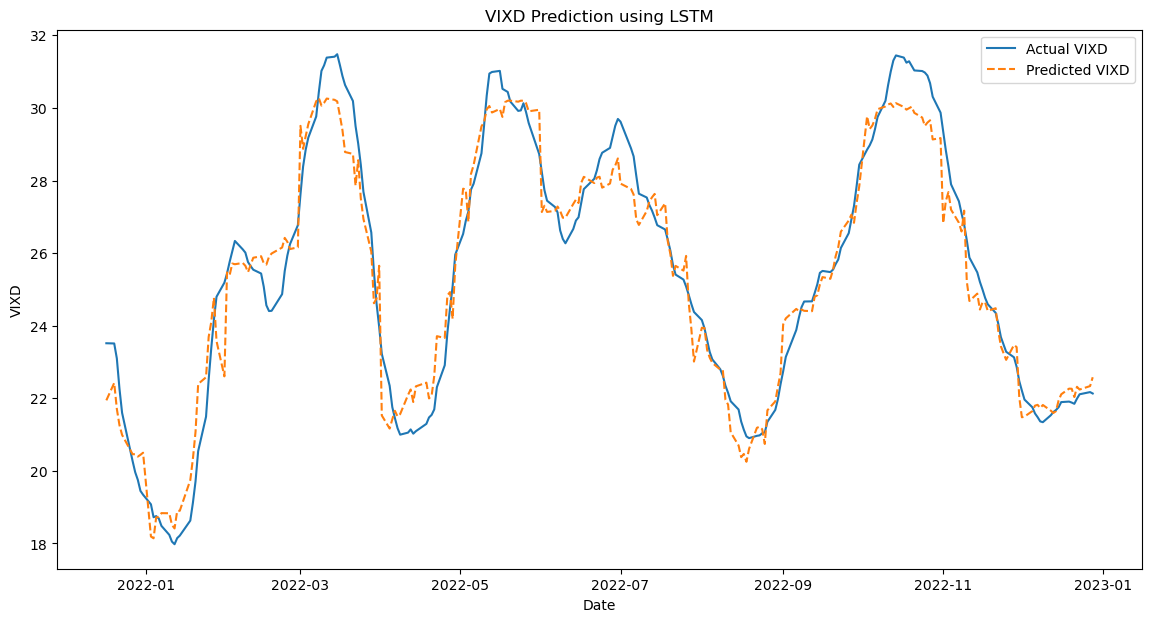

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# 加载情绪结果文件
finbert_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_finbert.xlsx')
textblob_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_textblob.xlsx')
vader_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_vader.xlsx')

# 加载市场指数数据
spxd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/_SPXD.xlsx', sheet_name='Price Data')
spxtrd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/_SPXTRD.xlsx', sheet_name='Price Data')
vixd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/VIXD.xlsx', sheet_name='Price Data')

# 确保日期列为datetime类型
finbert_data['Date'] = pd.to_datetime(finbert_data['Date'])
textblob_data['Date'] = pd.to_datetime(textblob_data['Date'])
vader_data['Date'] = pd.to_datetime(vader_data['Date'])
spxd_data['Date'] = pd.to_datetime(spxd_data['Date'])
spxtrd_data['Date'] = pd.to_datetime(spxtrd_data['Date'])
vixd_data['Date'] = pd.to_datetime(vixd_data['Date'])

# 将情绪得分扩展到每日
def expand_to_daily(data):
    daily_data = data.set_index('Date').resample('D').ffill().reset_index()
    return daily_data

finbert_data_daily = expand_to_daily(finbert_data)
textblob_data_daily = expand_to_daily(textblob_data)
vader_data_daily = expand_to_daily(vader_data)

# 合并情绪得分数据
sentiment_data = pd.merge(finbert_data_daily, textblob_data_daily, on='Date', how='outer', suffixes=('_finbert', '_textblob'))
sentiment_data = pd.merge(sentiment_data, vader_data_daily, on='Date', how='outer')

# 合并市场指数数据
market_data = pd.merge(spxd_data, spxtrd_data, on='Date', how='outer', suffixes=('_spxd', '_spxtrd'))
market_data = pd.merge(market_data, vixd_data, on='Date', how='outer')

# 合并所有数据
data = pd.merge(sentiment_data, market_data, on='Date', how='outer')
data.set_index('Date', inplace=True)

# 删除所有包含 NaN 值的行
data = data.dropna()

# 检查合并后的日期范围
print("Merged Data Date Range:")
print(data.index.min(), data.index.max())

X = data[['Overall Positive Sentiment', 'Overall Neutral Sentiment', 'Overall Negative Sentiment', 
          'Polarity', 'Subjectivity', 
          'Positive', 'Neutral', 'Negative', 
          'Average_SPXD', 'Close_SPXD', 'Close_SPXTRD', 'Average_SPXTRD']]
y = data['Average_VIXD'].shift(-1)

# 删除目标变量中的NaN值，并对齐特征变量的索引
y = y.dropna()
X = X.loc[y.index]

# 删除与目标变量对齐后的最后一行
X = X.iloc[:-1, :]
y = y.iloc[:-1]

# 调整特征权重
weights = {
    'Overall Positive Sentiment': 0.1,
    'Overall Neutral Sentiment': 0.7,
    'Overall Negative Sentiment': 0.1,
    'Polarity': 0.5,
    'Subjectivity': 0.5,
    'Positive': 0.1,
    'Neutral': 0.5,
    'Negative': 0.5,
    'Average_SPXD': 0.7,
    'Close_SPXD': 0.7,
    'Close_SPXTRD': 0.7,
    'Average_SPXTRD': 0.7
}
for col, weight in weights.items():
    X[col] = X[col] * weight

# 确保特征和目标变量的索引对齐
X = X.loc[y.index]
data = data.loc[y.index]  # 同步删除 data 中的对应行

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 拆分训练集、验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 重塑数据以适应LSTM输入 [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

from tensorflow.keras.regularizers import l2

# 构建LSTM模型
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(1, kernel_regularizer=l2(0.01)))

model.compile(optimizer='adam', loss='mse')

# 提前停止
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)  # 减少 patience

# 训练模型
history = model.fit(X_train, y_train, epochs=1000, batch_size=16, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=2, shuffle=False)

# 评估模型
y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation Mean Squared Error: {val_mse}')
print(f'Validation R^2 Score: {val_r2}')

# 在测试集上评估模型
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test Mean Squared Error: {test_mse}')
print(f'Test Root Mean Squared Error: {test_rmse}')
print(f'Test Mean Absolute Error: {test_mae}')
print(f'Test R^2 Score: {test_r2}')

# 可视化预测结果
predicted_vixd = model.predict(X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1])))
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Average_VIXD'], label='Actual VIXD')
plt.plot(data.index, predicted_vixd, label='Predicted VIXD', linestyle='--')
plt.xlabel('Date')
plt.ylabel('VIXD')
plt.title('VIXD Prediction using LSTM')
plt.legend()
plt.show()


In [5]:
import scipy.stats as stats

# 计算F统计量和P值的函数
def calculate_f_p_values(y_true, y_pred, model, X):
    n = len(y_true)  # 样本数
    k = X.shape[1]  # 特征数
    ssr = np.sum((y_pred.flatten() - y_true.mean()) ** 2)  # 回归平方和
    sse = np.sum((y_true - y_pred.flatten()) ** 2)  # 残差平方和
    msr = ssr / k  # 回归均方
    mse = sse / (n - k - 1)  # 残差均方
    f_stat = msr / mse  # F统计量
    p_value = stats.f.sf(f_stat, k, n - k - 1)  # P值
    return f_stat, p_value

# 对验证集进行计算
f_stat_val, p_value_val = calculate_f_p_values(y_val, y_val_pred, model, X_val.reshape(X_val.shape[0], X_val.shape[2]))
print(f'Validation F-statistic: {f_stat_val}')
print(f'Validation P-value: {p_value_val}')

# 对测试集进行计算
f_stat_test, p_value_test = calculate_f_p_values(y_test, y_test_pred, model, X_test.reshape(X_test.shape[0], X_test.shape[2]))
print(f'Test F-statistic: {f_stat_test}')
print(f'Test P-value: {p_value_test}')


Validation F-statistic: 71.87386271191374
Validation P-value: 9.778062934905355e-23
Test F-statistic: 67.68371636895614
Test P-value: 2.9565449483296654e-22


Merged Data Date Range:
2021-12-17 00:00:00 2022-12-30 00:00:00
Train on 156 samples, validate on 52 samples
Epoch 1/1000
156/156 - 9s - loss: 664.3882 - val_loss: 647.1037
Epoch 2/1000
156/156 - 0s - loss: 662.3133 - val_loss: 645.1108
Epoch 3/1000
156/156 - 0s - loss: 660.2847 - val_loss: 642.8591
Epoch 4/1000
156/156 - 0s - loss: 657.5922 - val_loss: 640.0887
Epoch 5/1000
156/156 - 0s - loss: 654.7040 - val_loss: 636.5183
Epoch 6/1000
156/156 - 0s - loss: 650.4768 - val_loss: 631.6295
Epoch 7/1000
156/156 - 0s - loss: 645.4652 - val_loss: 624.8428
Epoch 8/1000
156/156 - 0s - loss: 637.1135 - val_loss: 615.2377
Epoch 9/1000
156/156 - 0s - loss: 627.6828 - val_loss: 601.6808
Epoch 10/1000
156/156 - 0s - loss: 611.5225 - val_loss: 582.9941
Epoch 11/1000
156/156 - 0s - loss: 593.3724 - val_loss: 558.5005
Epoch 12/1000
156/156 - 0s - loss: 569.7714 - val_loss: 528.6745
Epoch 13/1000
156/156 - 0s - loss: 540.3268 - val_loss: 493.5105
Epoch 14/1000
156/156 - 0s - loss: 506.6322 - val_loss:

Epoch 129/1000
156/156 - 0s - loss: 26.3631 - val_loss: 15.1291
Epoch 130/1000
156/156 - 0s - loss: 22.0445 - val_loss: 15.1126
Epoch 131/1000
156/156 - 0s - loss: 26.9628 - val_loss: 15.0831
Epoch 132/1000
156/156 - 0s - loss: 24.1632 - val_loss: 15.0553
Epoch 133/1000
156/156 - 0s - loss: 22.6849 - val_loss: 15.0224
Epoch 134/1000
156/156 - 0s - loss: 25.7043 - val_loss: 14.9995
Epoch 135/1000
156/156 - 0s - loss: 23.1006 - val_loss: 14.9877
Epoch 136/1000
156/156 - 0s - loss: 29.3053 - val_loss: 14.9679
Epoch 137/1000
156/156 - 0s - loss: 29.2586 - val_loss: 14.9375
Epoch 138/1000
156/156 - 0s - loss: 29.3721 - val_loss: 14.9096
Epoch 139/1000
156/156 - 0s - loss: 24.7091 - val_loss: 14.8885
Epoch 140/1000
156/156 - 0s - loss: 21.7729 - val_loss: 14.8567
Epoch 141/1000
156/156 - 0s - loss: 22.8537 - val_loss: 14.8151
Epoch 142/1000
156/156 - 0s - loss: 22.7753 - val_loss: 14.7688
Epoch 143/1000
156/156 - 0s - loss: 22.2180 - val_loss: 14.7263
Epoch 144/1000
156/156 - 0s - loss: 25.0

Epoch 259/1000
156/156 - 0s - loss: 19.6933 - val_loss: 6.4539
Epoch 260/1000
156/156 - 0s - loss: 17.4901 - val_loss: 6.4124
Epoch 261/1000
156/156 - 0s - loss: 20.2568 - val_loss: 6.3724
Epoch 262/1000
156/156 - 0s - loss: 17.2571 - val_loss: 6.3473
Epoch 263/1000
156/156 - 0s - loss: 18.2495 - val_loss: 6.3655
Epoch 264/1000
156/156 - 0s - loss: 18.6176 - val_loss: 6.3667
Epoch 265/1000
156/156 - 0s - loss: 18.7319 - val_loss: 6.3921
Epoch 266/1000
156/156 - 0s - loss: 19.9925 - val_loss: 6.4291
Epoch 267/1000
156/156 - 0s - loss: 18.2674 - val_loss: 6.4506
Epoch 268/1000
156/156 - 0s - loss: 16.8487 - val_loss: 6.4287
Epoch 269/1000
156/156 - 0s - loss: 17.5354 - val_loss: 6.4151
Epoch 270/1000
156/156 - 0s - loss: 15.6251 - val_loss: 6.3641
Epoch 271/1000
156/156 - 0s - loss: 16.7797 - val_loss: 6.3843
Epoch 272/1000
156/156 - 0s - loss: 17.9554 - val_loss: 6.3798
Epoch 273/1000
156/156 - 0s - loss: 16.7274 - val_loss: 6.3712
Epoch 274/1000
156/156 - 0s - loss: 17.2199 - val_loss:

156/156 - 0s - loss: 13.3903 - val_loss: 4.1510
Epoch 390/1000
156/156 - 0s - loss: 13.5448 - val_loss: 4.1311
Epoch 391/1000
156/156 - 0s - loss: 14.7526 - val_loss: 4.1576
Epoch 392/1000
156/156 - 0s - loss: 14.8704 - val_loss: 4.1572
Epoch 393/1000
156/156 - 0s - loss: 14.1182 - val_loss: 4.1331
Epoch 394/1000
156/156 - 0s - loss: 12.7209 - val_loss: 4.1112
Epoch 395/1000
156/156 - 0s - loss: 13.5093 - val_loss: 4.1480
Epoch 396/1000
156/156 - 0s - loss: 14.9740 - val_loss: 4.2765
Epoch 397/1000
156/156 - 0s - loss: 16.2248 - val_loss: 4.3744
Epoch 398/1000
156/156 - 0s - loss: 14.9894 - val_loss: 4.3757
Epoch 399/1000
156/156 - 0s - loss: 15.4389 - val_loss: 4.3102
Epoch 400/1000
156/156 - 0s - loss: 13.2654 - val_loss: 4.1978
Epoch 401/1000
156/156 - 0s - loss: 12.2687 - val_loss: 4.1503
Epoch 402/1000
156/156 - 0s - loss: 13.5252 - val_loss: 4.1822
Epoch 403/1000
156/156 - 0s - loss: 14.3866 - val_loss: 4.2565
Epoch 404/1000
156/156 - 0s - loss: 11.8329 - val_loss: 4.2077
Epoch 4

Epoch 520/1000
156/156 - 0s - loss: 11.8223 - val_loss: 3.2503
Epoch 521/1000
156/156 - 0s - loss: 12.5580 - val_loss: 3.3013
Epoch 522/1000
156/156 - 0s - loss: 11.8986 - val_loss: 3.3258
Epoch 523/1000
156/156 - 0s - loss: 14.9402 - val_loss: 3.2377
Epoch 524/1000
156/156 - 0s - loss: 10.4961 - val_loss: 3.2576
Epoch 525/1000
156/156 - 0s - loss: 11.7956 - val_loss: 3.2560
Epoch 526/1000
156/156 - 0s - loss: 9.1664 - val_loss: 3.2173
Epoch 527/1000
156/156 - 0s - loss: 12.1030 - val_loss: 3.1622
Epoch 528/1000
156/156 - 0s - loss: 10.4391 - val_loss: 3.1449
Epoch 529/1000
156/156 - 0s - loss: 12.7482 - val_loss: 3.1663
Epoch 530/1000
156/156 - 0s - loss: 12.5319 - val_loss: 3.2305
Epoch 531/1000
156/156 - 0s - loss: 13.3335 - val_loss: 3.2980
Epoch 532/1000
156/156 - 0s - loss: 12.2703 - val_loss: 3.2651
Epoch 533/1000
156/156 - 0s - loss: 13.5016 - val_loss: 3.2182
Epoch 534/1000
156/156 - 0s - loss: 14.6240 - val_loss: 3.1930
Epoch 535/1000
156/156 - 0s - loss: 12.6699 - val_loss: 

156/156 - 0s - loss: 11.6006 - val_loss: 2.8839
Epoch 651/1000
156/156 - 0s - loss: 11.2665 - val_loss: 2.8653
Epoch 652/1000
156/156 - 0s - loss: 13.2232 - val_loss: 2.8917
Epoch 653/1000
156/156 - 0s - loss: 11.5646 - val_loss: 2.8842
Epoch 654/1000
156/156 - 0s - loss: 11.9612 - val_loss: 2.8432
Epoch 655/1000
156/156 - 0s - loss: 9.8131 - val_loss: 2.7945
Epoch 656/1000
156/156 - 0s - loss: 12.5355 - val_loss: 2.7423
Epoch 657/1000
156/156 - 0s - loss: 12.3171 - val_loss: 2.7439
Epoch 658/1000
156/156 - 0s - loss: 11.5548 - val_loss: 2.7386
Epoch 659/1000
156/156 - 0s - loss: 10.2604 - val_loss: 2.7371
Epoch 660/1000
156/156 - 0s - loss: 11.3745 - val_loss: 2.7273
Epoch 661/1000
156/156 - 0s - loss: 13.6488 - val_loss: 2.7492
Epoch 662/1000
156/156 - 0s - loss: 12.4151 - val_loss: 2.8302
Epoch 663/1000
156/156 - 0s - loss: 12.3891 - val_loss: 2.9796
Epoch 664/1000
156/156 - 0s - loss: 12.9551 - val_loss: 2.8451
Epoch 665/1000
156/156 - 0s - loss: 11.0596 - val_loss: 2.7689
Epoch 66

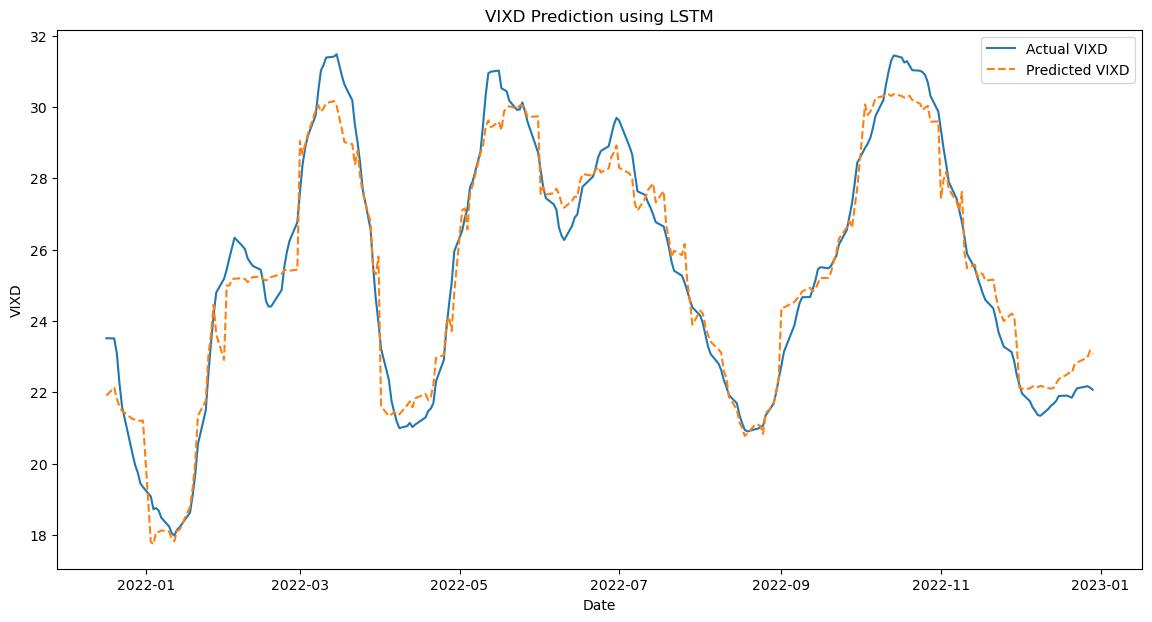

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 加载情绪结果文件
finbert_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_finbert.xlsx')
textblob_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_textblob.xlsx')
vader_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_vader.xlsx')

# 加载市场指数数据
spxd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/_SPXD.xlsx', sheet_name='Price Data')
spxtrd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/_SPXTRD.xlsx', sheet_name='Price Data')
vixd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/VIXD.xlsx', sheet_name='Price Data')

# 确保日期列为datetime类型
finbert_data['Date'] = pd.to_datetime(finbert_data['Date'])
textblob_data['Date'] = pd.to_datetime(textblob_data['Date'])
vader_data['Date'] = pd.to_datetime(vader_data['Date'])
spxd_data['Date'] = pd.to_datetime(spxd_data['Date'])
spxtrd_data['Date'] = pd.to_datetime(spxtrd_data['Date'])
vixd_data['Date'] = pd.to_datetime(vixd_data['Date'])

# 将情绪得分扩展到每日
def expand_to_daily(data):
    daily_data = data.set_index('Date').resample('D').ffill().reset_index()
    return daily_data

finbert_data_daily = expand_to_daily(finbert_data)
textblob_data_daily = expand_to_daily(textblob_data)
vader_data_daily = expand_to_daily(vader_data)

# 合并情绪得分数据
sentiment_data = pd.merge(finbert_data_daily, textblob_data_daily, on='Date', how='outer', suffixes=('_finbert', '_textblob'))
sentiment_data = pd.merge(sentiment_data, vader_data_daily, on='Date', how='outer')

# 合并市场指数数据
market_data = pd.merge(spxd_data, spxtrd_data, on='Date', how='outer', suffixes=('_spxd', '_spxtrd'))
market_data = pd.merge(market_data, vixd_data, on='Date', how='outer')

# 合并所有数据
data = pd.merge(sentiment_data, market_data, on='Date', how='outer')
data.set_index('Date', inplace=True)

# 删除所有包含 NaN 值的行
data = data.dropna()

# 检查合并后的日期范围
print("Merged Data Date Range:")
print(data.index.min(), data.index.max())
lag = 2
X = data[['Overall Positive Sentiment', 'Overall Neutral Sentiment', 'Overall Negative Sentiment', 
          'Polarity', 'Subjectivity', 
          'Positive', 'Neutral', 'Negative', 
          'Average_SPXD', 'Close_SPXD', 'Close_SPXTRD', 'Average_SPXTRD']]

# Apply lag to the features
X_lagged = X.shift(lag)
y = data['Average_VIXD']


# 删除目标变量中的NaN值，并对齐特征变量的索引
y = y.dropna()
X = X.loc[y.index]

# 删除与目标变量对齐后的最后一行
X = X.iloc[:-1, :]
y = y.iloc[:-1]

# 调整特征权重
weights = {
    'Overall Positive Sentiment': 0.1,
    'Overall Neutral Sentiment': 0.7,
    'Overall Negative Sentiment': 0.1,
    'Polarity': 0.8,
    'Subjectivity': 0.5,
    'Positive': 0.1,
    'Neutral': 0.1,
    'Negative': 0.5,
    'Average_SPXD': 0.7,
    'Close_SPXD': 0.7,
    'Close_SPXTRD': 0.7,
    'Average_SPXTRD': 0.7
}
for col, weight in weights.items():
    X[col] = X[col] * weight

# 确保特征和目标变量的索引对齐
X = X.loc[y.index]
data = data.loc[y.index]  # 同步删除 data 中的对应行

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 拆分训练集、验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 重塑数据以适应LSTM输入 [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

from tensorflow.keras.regularizers import l2

# 构建LSTM模型
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(1, kernel_regularizer=l2(0.01)))

model.compile(optimizer='adam', loss='mse')

# 提前停止
early_stopping = EarlyStopping(monitor='val_loss', patience=33, restore_best_weights=True)  # 减少 patience

# 训练模型
history = model.fit(X_train, y_train, epochs=1000, batch_size=16, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=2, shuffle=False)

# 在验证集上评估模型
y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation Mean Squared Error: {val_mse}')
print(f'Validation Root Mean Squared Error: {val_rmse}')
print(f'Validation Mean Absolute Error: {val_mae}')
print(f'Validation R^2 Score: {val_r2}')

# 在测试集上评估模型
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test Mean Squared Error: {test_mse}')
print(f'Test Root Mean Squared Error: {test_rmse}')
print(f'Test Mean Absolute Error: {test_mae}')
print(f'Test R^2 Score: {test_r2}')

# 可视化预测结果
predicted_vixd = model.predict(X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1])))
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Average_VIXD'], label='Actual VIXD')
plt.plot(data.index, predicted_vixd, label='Predicted VIXD', linestyle='--')
plt.xlabel('Date')
plt.ylabel('VIXD')
plt.title('VIXD Prediction using LSTM')
plt.legend()
plt.show()


In [12]:
import scipy.stats as stats

# 计算F统计量和P值的函数
def calculate_f_p_values(y_true, y_pred, model, X):
    n = len(y_true)  # 样本数
    k = X.shape[1]  # 特征数
    ssr = np.sum((y_pred.flatten() - y_true.mean()) ** 2)  # 回归平方和
    sse = np.sum((y_true - y_pred.flatten()) ** 2)  # 残差平方和
    msr = ssr / k  # 回归均方
    mse = sse / (n - k - 1)  # 残差均方
    f_stat = msr / mse  # F统计量
    p_value = stats.f.sf(f_stat, k, n - k - 1)  # P值
    return f_stat, p_value

# 对验证集进行计算
f_stat_val, p_value_val = calculate_f_p_values(y_val, y_val_pred, model, X_val.reshape(X_val.shape[0], X_val.shape[2]))
print(f'Validation F-statistic: {f_stat_val}')
print(f'Validation P-value: {p_value_val}')

# 对测试集进行计算
f_stat_test, p_value_test = calculate_f_p_values(y_test, y_test_pred, model, X_test.reshape(X_test.shape[0], X_test.shape[2]))
print(f'Test F-statistic: {f_stat_test}')
print(f'Test P-value: {p_value_test}')


Validation F-statistic: 71.45531783589949
Validation P-value: 1.0890442138305118e-22
Test F-statistic: 69.91305650653698
Test P-value: 1.6282953406514728e-22
